In [75]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [76]:
with open("../../scheme_scores_4_adaptive.pickle", "rb") as f:
    scheme_scores_4_adaptive = pickle.load(f)

In [77]:
plot_axes = [
    "t_g"
]
iso_axes = {
    "Ec": 1.3,
    "El": 0.59,
    "Ej": 5.71,
    "L1": 1.58e-4,
    "L2": 1.58e-4,
}

Doing 1D plot
Length of set: 32
Of which, 0 where thrown out due to timeouts
Of which, 17 where thrown out due to other errors


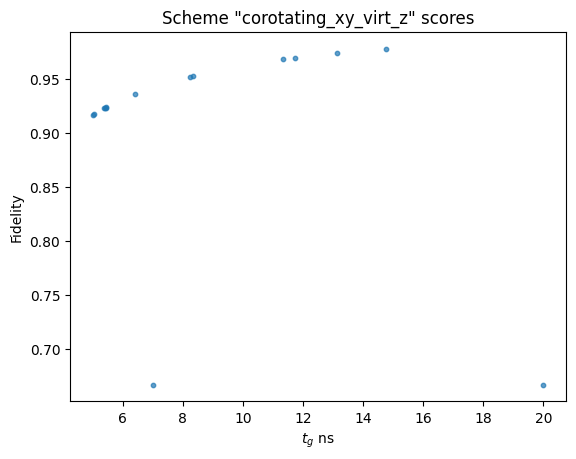

In [78]:
if len(plot_axes) == 1:
    print("Doing 1D plot")
    for key in scheme_scores_4_adaptive:#key is just the gate that is attempted
        datapoints = scheme_scores_4_adaptive[key]
        print(f"Length of set: {len(datapoints)}")
        timeouts = 0
        for i,dp in enumerate(datapoints):
            if "timeout" in dp.keys() and dp["timeout"]:
                timeouts += 1
        print(f"Of which, {timeouts} where thrown out due to timeouts")
        other_errors = 0
        for i,dp in enumerate(datapoints):
            if dp["score"] == None:
                other_errors += 1
        print(f"Of which, {other_errors-timeouts} where thrown out due to other errors")
        distance_2_isoaxis = np.zeros(len(datapoints))
        for i,dp in enumerate(datapoints):
            for ia in iso_axes:
                distance_2_isoaxis[i] += (dp[ia] - iso_axes[ia])**2
        distance_2_isoaxis = np.sqrt(distance_2_isoaxis)
        plot_axis = np.full(len(datapoints), np.nan)
        for i,dp in enumerate(datapoints):
            plot_axis[i] = dp[plot_axes[0]]
        scores = np.zeros(len(datapoints))
        for i,dp in enumerate(datapoints):
            scores[i] = dp["score"]
        nanmask = np.isnan(plot_axis) & np.isnan(scores)
        plot_axis = plot_axis[~nanmask]
        scores = scores[~nanmask]
        distance_2_isoaxis = distance_2_isoaxis[~nanmask]
        """distance_cut_mask = distance_2_isoaxis < 1*np.max(distance_2_isoaxis)
        enable_color = True
        plot_axis = plot_axis[distance_cut_mask]
        scores = scores[distance_cut_mask]
        distance_2_isoaxis = distance_2_isoaxis[distance_cut_mask]"""
        #make a cmap after the distance to the plot axis
        if False:#enable_color:
            cmap = plt.cm.hot
            norm = LogNorm(np.min(distance_2_isoaxis), np.max(distance_2_isoaxis))
            plt.scatter(plot_axis, scores, c=distance_2_isoaxis, cmap=cmap, norm=norm, s=10, alpha=0.7)
            plt.colorbar(label="Distance to isoaxis")
        else:
            plt.scatter(plot_axis, scores, s=10, alpha=0.7)
        plt.title(f'Scheme "{key}" scores')
        plt.xlabel(fr"${plot_axes[0]}$ ns")
        plt.ylabel("Fidelity")
        #plt.xscale("log")
        plt.show()


In [79]:
plot_axes = [
    "t_g",
    "alpha"
]
iso_axes = {
    "Ec": 1.3,
    "El": 0.59,
    "L1": 1.58e-4,
    "L2": 1.58e-4,
}

In [80]:
if len(plot_axes) == 2:
    print("Doing 2D plot")
    for key in scheme_scores_4_adaptive:
        datapoints = scheme_scores_4_adaptive[key]
        #check if plot axes are present
        mask = np.zeros(len(datapoints), dtype=bool)
        for i,dp in enumerate(datapoints):
            mask[i] = True
            for pa in plot_axes:
                if not pa in dp.keys():
                    mask[i] = False
        datapoints = [dp for i,dp in enumerate(datapoints) if mask[i]]
        print(f"Threw out {np.sum(~mask)} datapoints")
        print(f"Length of set: {len(datapoints)}")
        timeouts = 0
        for i,dp in enumerate(datapoints):
            if "timeout" in dp.keys() and dp["timeout"]:
                timeouts += 1
        print(f"Timeouts for scheme {key}: {timeouts}")
        distance_2_isoaxis = np.zeros(len(datapoints))
        for i,dp in enumerate(datapoints):
            for ia in iso_axes:
                distance_2_isoaxis[i] += (dp[ia] - iso_axes[ia])**2
        distance_2_isoaxis = np.sqrt(distance_2_isoaxis)
        plot_axis_x = np.full(len(datapoints), np.nan)
        plot_axis_y = np.full(len(datapoints), np.nan)
        for i,dp in enumerate(datapoints):
            plot_axis_x[i] = dp[plot_axes[0]]
            plot_axis_y[i] = dp[plot_axes[1]]
        scores = np.zeros(len(datapoints))
        for i,dp in enumerate(datapoints):
            scores[i] = dp["score"]
        nanmask = np.isnan(plot_axis_x) & np.isnan(scores)
        plot_axis_x = plot_axis_x[~nanmask]
        plot_axis_y = plot_axis_y[~nanmask]
        scores = scores[~nanmask]
        distance_2_isoaxis = distance_2_isoaxis[~nanmask]
        #do a k=2 nearest neighbour plot
        from sklearn.neighbors import NearestNeighbors
        nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(np.array([plot_axis_x, plot_axis_y]).T)
        X = np.linspace(np.min(plot_axis_x), np.max(plot_axis_x), 100)
        Y = np.linspace(np.min(plot_axis_y), np.max(plot_axis_y), 100)
        X, Y = np.meshgrid(X, Y)
        Z = np.zeros(X.shape)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                distances, indices = nbrs.kneighbors(np.array([[X[i,j], Y[i,j]]]))
                Z[i,j] = scores[indices[0][1]]
        #as a first simple thing: plot this
        plt.imshow(Z, extent=(np.min(plot_axis_x), np.max(plot_axis_x), np.min(plot_axis_y), np.max(plot_axis_y)), origin="lower", aspect="auto")
        plt.colorbar(label="Fidelity")
        plt.title(f'Scheme "{key}" scores')
        plt.xlabel(fr"${plot_axes[0]}$ ns")
        plt.ylabel(fr"${plot_axes[1]}$ ns")
        plt.scatter(plot_axis_x, plot_axis_y, c=distance_2_isoaxis, cmap="hot", norm=LogNorm(np.min(distance_2_isoaxis), np.max(distance_2_isoaxis)), s=10, alpha=0.7)
        plt.colorbar(label="Distance to isoaxis")
        plt.show()


Doing 2D plot
Threw out 32 datapoints
Length of set: 0
Timeouts for scheme corotating_xy_virt_z: 0


ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required by NearestNeighbors.